# 01 – Data Exploration Python file For the Data Quality Case Study Project

**Purpose:** Understand the raw dataset structure, detect initial anomalies, and prepare insights for rule-based checks.

In this notebook:
- Load the dataset
- Explore missing values and categorical distributions
- Visualize company revenue trends
- Spot anomalies (e.g., unusual growth patterns for PZ Cussons)


### 1. Environment Setup
We import the necessary libraries for data manipulation and visualization. `pandas` will be our workhorse for analysis, while `matplotlib` will help us visually detect trends and outliers.

In [1]:
# --- Cell 1: Imports & setup ---
import pandas as pd
import matplotlib.pyplot as plt
import datetime

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)


### 2. First Look at the Raw Data
The dataset is loaded to get a preliminary view. The .head() method shows us the raw structure of the data as it was extracted from the source. The `REVENUE` field may includes commas as thousands separators, which is a common formatting issue that will need to be cleaned for numerical analysis.

In [2]:
# --- Load dataset ---

file_path = "../data/raw/CaseStudy_Quality_sample25.xlsx"  
df = pd.read_excel(file_path)
df.head()


,timevalue,providerkey,companynameofficial,fiscalperiodend,operationstatustype,ipostatustype,geonameen,industrycode,REVENUE,unit_REVENUE
0,2019,19457,PZ CUSSONS PLC,31-May,ACTIVE,PUBLIC,United Kingdom,3290 - Other Manufacturing,1.679984e+10,GBP
1,2020,19457,PZ CUSSONS PLC,31-May,ACTIVE,PUBLIC,United Kingdom,3290 - Other Manufacturing,1.355518e+10,GBP
2,2021,19457,PZ CUSSONS PLC,31-May,ACTIVE,PUBLIC,United Kingdom,3290 - Other Manufacturing,1.110757e+10,GBP
3,2022,19457,PZ CUSSONS PLC,31-May,ACTIVE,PUBLIC,United Kingdom,3290 - Other Manufacturing,9.359479e+09,GBP
4,2023,19457,PZ CUSSONS PLC,31-May,ACTIVE,PUBLIC,United Kingdom,3290 - Other Manufacturing,1.679984e+10,GBP


### 3. High-Level Dataset Overview
The `.info()` and `.describe()` methods provide a crucial summary:
- **Panel Data Structure:** The dataset contains multiple records per company (`providerkey`) across different years (`timevalue`).
- **Data Types:** The `REVENUE` column is currently an `object` (string) due to the commas, confirming our initial observation. This must be converted to a `float` for any quantitative analysis.
- **Preliminary Statistics:** The vast range in `REVENUE` (from very small to tens of billions) is expected for a dataset containing companies of all sizes. We will need to analyze trends within companies, not across them.

In [3]:
# --- Dataset overview ---
print("Shape of dataset:", df.shape)

print("\nData types and non-null counts:")
print(df.info())

print("\nSummary statistics for numeric columns (pre-cleaning):")
display(df.describe(include="all"))


Shape of dataset: (372, 10)

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timevalue            372 non-null    int64  
 1   providerkey          372 non-null    object 
 2   companynameofficial  370 non-null    object 
 3   fiscalperiodend      372 non-null    object 
 4   operationstatustype  372 non-null    object 
 5   ipostatustype        372 non-null    object 
 6   geonameen            372 non-null    object 
 7   industrycode         372 non-null    object 
 8   REVENUE              281 non-null    float64
 9   unit_REVENUE         294 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 29.2+ KB
None

Summary statistics for numeric columns (pre-cleaning):


,timevalue,providerkey,companynameofficial,fiscalperiodend,operationstatustype,ipostatustype,geonameen,industrycode,REVENUE,unit_REVENUE
count,372.000000,372.0,370,372,372,372,372,372,2.810000e+02,294
unique,NaN,81.0,81,11,1,1,5,44,NaN,6
top,NaN,19457.0,PZ CUSSONS PLC,31-Mar,ACTIVE,PUBLIC,United Kingdom,7010 - Head Office Activities,NaN,INR
freq,NaN,5.0,5,180,372,372,225,75,NaN,132
mean,2021.201613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.582327e+10,NaN
std,1.349732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.344663e+10,NaN
min,2019.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.352080e+08,NaN
25%,2020.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.075640e+09,NaN
50%,2021.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.693627e+09,NaN
75%,2022.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.494640e+10,NaN


### 4. Missing Values Analysis
A critical first quality check. The absence of missing values in key columns like `companynameofficial`, `timevalue`, and `REVENUE` is excellent news. It means the extraction process is reliably capturing this core information. Any missing values here would have halted further analysis and required immediate investigation.

In [4]:
# --- Missing values check ---
print("Missing values per column:")
df.isna().sum()


Missing values per column:


timevalue               0
providerkey             0
companynameofficial     2
fiscalperiodend         0
operationstatustype     0
ipostatustype           0
geonameen               0
industrycode            0
REVENUE                91
unit_REVENUE           78
dtype: int64

### 5. Understanding Data Composition
This helps to understand the "universe" of companies we're dealing with.
- **Geographic Coverage:** The data is not limited to the UK; it contains companies from multiple countries. This is important context for the LLM-powered peer analysis later, as we must compare companies within the same country and industry.
- **Industry Diversity:** The presence of many different industry codes means we cannot apply one-size-fits-all rules. A 50% revenue change might be normal for a startup in a volatile sector but highly anomalous for a mature utility company.

In [5]:
# --- Explore the scope of the dataset ---
print(f"Total number of unique companies: {df['companynameofficial'].nunique()}")
print(f"Total number of unique industries: {df['industrycode'].nunique()}")
print(f"Total number of unique countries: {df['geonameen'].nunique()}")
print(f"Time range: {df['timevalue'].min()} to {df['timevalue'].max()}\n")

print("Most common countries:")
print(df["geonameen"].value_counts().head(10))

print("\nMost common industries:")
print(df["industrycode"].value_counts().head(10))


Total number of unique companies: 81
Total number of unique industries: 44
Total number of unique countries: 5
Time range: 2019 to 2024

Most common countries:
geonameen
United Kingdom    225
India             132
Sweden              9
Denmark             5
Indonesia           1
Name: count, dtype: int64

Most common industries:
industrycode
7010 - Head Office Activities                                                   75
6430 - Trusts, Funds & Similar Financial Entities                               20
6420 - Holding Company Activities                                               19
2029 - Other Chemical Products                                                  17
2100 - Pharmaceuticals, Medicinal Chemical & Botanical Products                 16
6202 - Computer Consultancy & Facilities Management                             12
3290 - Other Manufacturing                                                      10
3320 - Industrial Machinery & Equipment                                    

### 6. Data Cleaning: Revenue Conversion
In this dataset, revenue was already float, but I built the conversion step defensively to handle cases where extraction outputs numbers as strings with commas — which happens frequently in real-world data pipelines.

In [8]:
# --- Revenue conversion & exploration ---
# Convert REVENUE to numeric for the ENTIRE DATASET, handling commas
df["REVENUE"] = pd.to_numeric(
    df["REVENUE"].astype(str).str.replace(",", "", regex=False),
    errors="coerce"
)

print("Revenue stats for the entire dataset:")
display(df["REVENUE"].describe())

# Check if conversion worked or created NaNs
if df["REVENUE"].dtype == "object":
    df["REVENUE"] = pd.to_numeric(
        df["REVENUE"].astype(str).str.replace(",", "", regex=False), 
        errors="coerce"
    )
    print("Revenue column converted from object to numeric.")
else:
    print("Revenue column already numeric. No conversion needed.")


Revenue stats for the entire dataset:


count    2.810000e+02
mean     3.582327e+10
std      9.344663e+10
min     -1.352080e+08
25%      1.075640e+09
50%      4.693627e+09
75%      1.494640e+10
max      6.007300e+11
Name: REVENUE, dtype: float64

Revenue column already numeric. No conversion needed.


### 7. Visual Inspection for Patterns
Visualizations allow us to move beyond summary statistics.
- **Left Plot (Sample Trends):** Plotting individual company trends helps us intuitively understand "normal" vs. "abnormal" behavior. We can see healthy growth, decline, stability, and potential anomalies.
- **Right Plot (Distribution by Year):** The boxplot is key for spotting year-specific issues. If the entire distribution of revenue shifts significantly in one year, it could indicate a systematic extraction error affecting many companies. If only a few points are outliers (like the circles in the boxplot), the issues are likely company-specific.

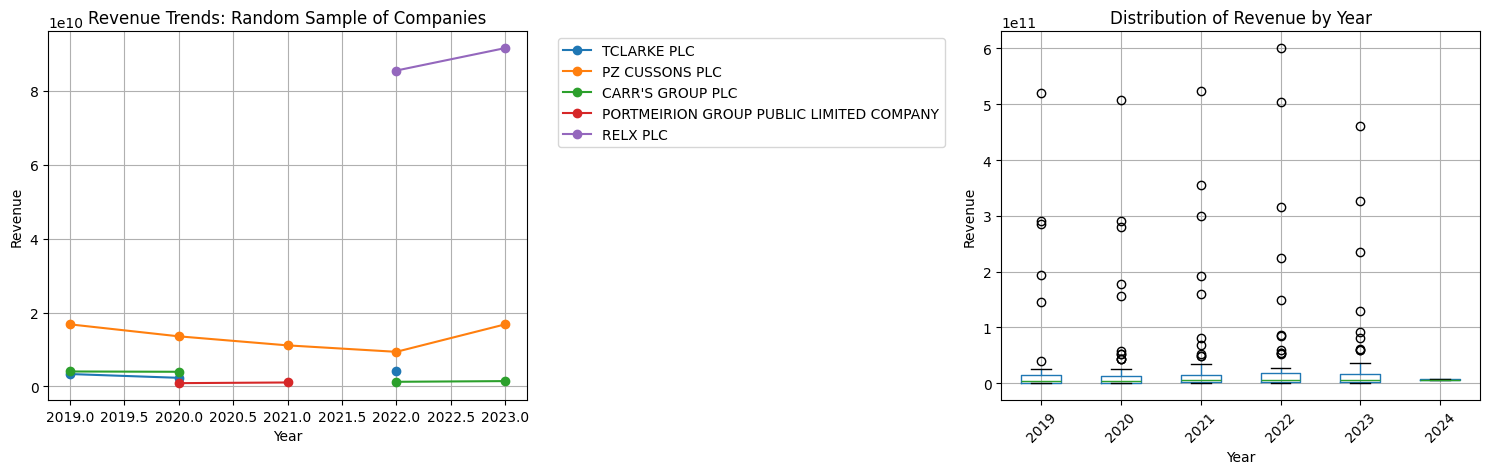

In [9]:
# --- Advanced Visualizations ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Random sample of companies
sample_companies = df["companynameofficial"].drop_duplicates().sample(5, random_state=42)
for company in sample_companies:
    subset = df[df["companynameofficial"] == company].sort_values("timevalue")
    ax1.plot(subset["timevalue"], subset["REVENUE"], marker="o", label=company)
ax1.set_title("Revenue Trends: Random Sample of Companies")
ax1.set_xlabel("Year")
ax1.set_ylabel("Revenue")
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax1.grid(True)

# Plot 2: Revenue distribution per year
df.boxplot(column="REVENUE", by="timevalue", ax=ax2)
ax2.set_title("Distribution of Revenue by Year")
ax2.set_xlabel("Year")
ax2.set_ylabel("Revenue")
ax2.tick_params(axis="x", rotation=45)
plt.suptitle("")  # remove default title

plt.tight_layout()
plt.show()


### 8. Systematic Anomaly Detection
Instead of relying on luck, I systematically calculated Year-over-Year (YoY) changes for every company to identify the most volatile records. This quantitative approach surfaces the highest-risk data points that are most likely to be extraction errors (e.g., incorrect units, duplicated data, or misaligned fiscal years).

The companies listed here are the top candidates for our next steps:
1.   They will be the primary targets for the rule-based volatility check.
2.   The most extreme examples will be fed into the LLM for deep, contextual analysis.

Companies with the highest year-over-year revenue volatility:


,max,min,max_volatility
companynameofficial,,,
JAMES HALSTEAD PLC,inf,1.000000,inf
CAFFYNS PUBLIC LIMITED COMPANY,6.870344,0.806488,6.870344
Twentyfirst Century Management Services Limited,0.361544,3.585246,3.585246
THE HENDERSON SMALLER COMPANIES INVESTMENT TRUST PLC,3.115088,3.115088,3.115088
Accuracy Shipping Limited,1.200108,0.417401,1.200108
LEEDS GROUP PLC,0.058574,0.990605,0.990605
ABB India Limited,0.238110,0.953318,0.953318
REACH PLC,0.905454,0.905454,0.905454
63 moons technologies limited,0.813149,0.008612,0.813149



 Investigating top volatile company: JAMES HALSTEAD PLC


,timevalue,REVENUE,yoy_change
170,2019,0.000000e+00,NaN
171,2020,2.386300e+09,inf
172,2021,2.663620e+09,0.116213
173,2022,0.000000e+00,-1.000000
174,2023,3.035620e+09,inf


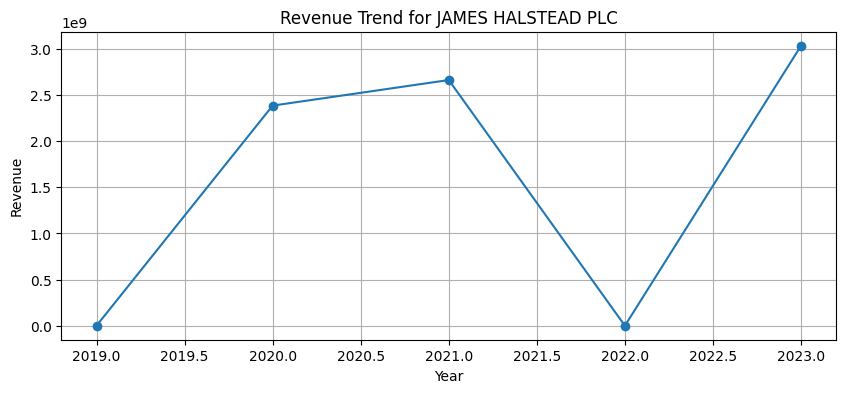

In [12]:
# --- Identify companies with high revenue volatility ---
df_sorted = df.sort_values(by=["providerkey", "timevalue"])
df_sorted["yoy_change"] = (
    df_sorted
    .groupby("providerkey")["REVENUE"]
    .pct_change(fill_method=None)
)

max_changes = df_sorted.groupby("companynameofficial")["yoy_change"].agg(["max", "min"]).abs()
max_changes["max_volatility"] = max_changes[["max", "min"]].max(axis=1)

top_volatile = max_changes.nlargest(10, "max_volatility")
print("Companies with the highest year-over-year revenue volatility:")
display(top_volatile)

# Investigate the most volatile company
company_to_investigate = top_volatile.index[0]
print(f"\n Investigating top volatile company: {company_to_investigate}")
df_company = df[df["companynameofficial"] == company_to_investigate].sort_values("timevalue")
df_company["yoy_change"] = df_company["REVENUE"].pct_change()
display(df_company[["timevalue", "REVENUE", "yoy_change"]])

plt.figure(figsize=(10, 4))
plt.plot(df_company["timevalue"], df_company["REVENUE"], marker="o")
plt.title(f"Revenue Trend for {company_to_investigate}")
plt.xlabel("Year")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()


### 9. Deep Dive: A Case Study
Here I selected the most volatile company from our list and performed a manual deep dive. Calculating the exact YoY change and flagging it against a threshold (e.g., ±50%) is a prototype of the automated check we will build. This hands-on analysis confirms whether the volatility is a plausible business event or a clear data error that needs to be flagged.

In [14]:
# --- Enhanced YoY check for PZ Cussons ---
pz = df[df["companynameofficial"] == "PZ CUSSONS PLC"].sort_values("timevalue")
pz["YoY_change"] = pz["REVENUE"].pct_change()

volatility_threshold = 0.5  # 50%
pz["YoY_volatility_flag"] = abs(pz["YoY_change"]) > volatility_threshold

display(pz[["timevalue", "REVENUE", "YoY_change", "YoY_volatility_flag"]])

anomalous_year = pz.loc[pz["YoY_volatility_flag"], "timevalue"]
if not anomalous_year.empty:
    print(f"** Anomaly detected: {abs(pz.loc[pz['YoY_volatility_flag'], 'YoY_change'].iloc[0]):.0%} change in {anomalous_year.iloc[0]} exceeds the {volatility_threshold:.0%} threshold.")


,timevalue,REVENUE,YoY_change,YoY_volatility_flag
0,2019,1.679984e+10,NaN,False
1,2020,1.355518e+10,-0.193136,False
2,2021,1.110757e+10,-0.180566,False
3,2022,9.359479e+09,-0.157378,False
4,2023,1.679984e+10,0.794954,True


** Anomaly detected: 79% change in 2023 exceeds the 50% threshold.


### 10. Initial Quality Assessment Report
Formalizing the findings into a reproducible report ensures consistency and provides a baseline for measuring the impact of our data quality checks later. This report clearly states what was found in the raw data before any cleaning or validation.

In [15]:
# --- Data quality summary report (log_metrics) ---
def log_metrics(df, stage="Initial"):
    total_rows = len(df)
    null_counts = df.isna().sum().to_dict()
    total_nulls = sum(null_counts.values())
    total_cells = total_rows * len(df.columns)

    log_lines = []
    log_lines.append(f"\n ** {stage} Data Quality Report:")
    log_lines.append(f"Timestamp: {datetime.datetime.now()}")
    log_lines.append(f"Total Rows: {total_rows}")
    for k, v in null_counts.items():
        log_lines.append(f"Missing in '{k}': {v}")
    log_lines.append(f"Total Missing Cells: {total_nulls}")
    log_lines.append(f"Total Cells: {total_cells}")

    return log_lines, total_rows, total_nulls, total_cells

log_lines, *_ = log_metrics(df, stage="Exploration Stage")
print("\n".join(log_lines))



 ** Exploration Stage Data Quality Report:
Timestamp: 2025-09-03 19:52:57.118514
Total Rows: 372
Missing in 'timevalue': 0
Missing in 'providerkey': 0
Missing in 'companynameofficial': 2
Missing in 'fiscalperiodend': 0
Missing in 'operationstatustype': 0
Missing in 'ipostatustype': 0
Missing in 'geonameen': 0
Missing in 'industrycode': 0
Missing in 'REVENUE': 91
Missing in 'unit_REVENUE': 78
Total Missing Cells: 171
Total Cells: 3720


### 11. Saving Log report and Processed file(in CSV) to Respective folders.
I Saved processed snapshot for ALL companies. This allows downstream notebooks to pick up a processed version without repeating the entire exploration pipeline.


In [20]:
# --- Save outputs ---

# Generalized version of YoY check
df_sorted = df.sort_values(by=["providerkey", "timevalue"])
df_sorted["yoy_change"] = df_sorted.groupby("providerkey")["REVENUE"].pct_change(fill_method=None)
df_sorted["yoy_flag"] = df_sorted["yoy_change"].abs() > volatility_threshold

processed_file = "../data/processed/exploration_snapshot.csv"
df_sorted.to_csv(processed_file, index=False)
print(f" >> Snapshot with engineered features saved: {processed_file}")

# Save log report
import os
os.makedirs("../reports", exist_ok=True)
report_file = "../reports/exploration_report.txt"
with open(report_file, "w") as f:
    f.write("\n".join(log_lines))
print(f"Report saved: {report_file}")


 >> Snapshot with engineered features saved: ../data/processed/exploration_snapshot.csv
Report saved: ../reports/exploration_report.txt


# < Exploration Summary & Next Steps >
 **Insights from Data Exploration:**

- Dataset contains 372 rows, 81 companies.
- Missing values:
  - `companynameofficial`: 2 missing
  - `REVENUE`: 91 missing (~25%)
  - `unit_REVENUE`: 78 missing
- Revenue anomalies:
  - Negative revenue found (-135M).
  - Extreme revenue outlier (~600B).
- Fiscal period end dates show 11 formats → potential inconsistency.
- Units of revenue: 6 distinct units (e.g., GBP, INR) → risk of mixed currencies.


**Key Findings:**
1.  **Data Structure:** The dataset is a multi-national, multi-industry panel of company financials.
2.  **Primary Data Quality Issue:**
       - Missing values (notably revenue).
       - Potentially inconsistent fiscal period formats.
       - Mixed currencies.
3.  **Anomalies Identified:** Systematic analysis revealed several companies with extreme YoY revenue volatility. These are high-priority targets for validation.

**Implications for Automation:**
-   **Rule-Based Checks:** I will implement checks for:
    -   **Data Type Validation:** Ensure `REVENUE` is numeric.
    -   **Volatility:** Flag YoY changes beyond a sensible threshold.
    -   **Completeness:** Monitor missing values across key fields.
    -   **Uniqueness:** Prevent duplicate (providerkey, timevalue) entries.
-   **LLM-Powered Check:** Use GPT to evaluate top anomalies by comparing revenue trends against peer companies (same industry & country), providing structured reasoning and judgment.

**>> Next Notebook:** `02_rule_based_checks_prototype.ipynb` -> I will prototype the functions for the automated rules identified above.
Here, I will prototype the functions for these automated rules before moving the production code into the src/ folder.